In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from cryptography.hazmat.primitives.ciphers import (
    Cipher, algorithms, modes
)

In [18]:
def show_pic(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    ax.imshow(img)
#     plt.title(name)

# Function to convert the input message to Binary..

In [19]:
def pixel2binary(pixel):
    
  if type(pixel) == bytes:
    result= [ format(i, "08b") for i in message  ]
    
  else:
    raise TypeError("Input type is not supported")
    
  return result  

In [20]:
def cipher2binary(message):
    
  if type(message) == bytes:
    result= ''.join([ format(i, "08b") for i in message ])

  else:
    raise TypeError("Input type is not supported")
    
  return result  

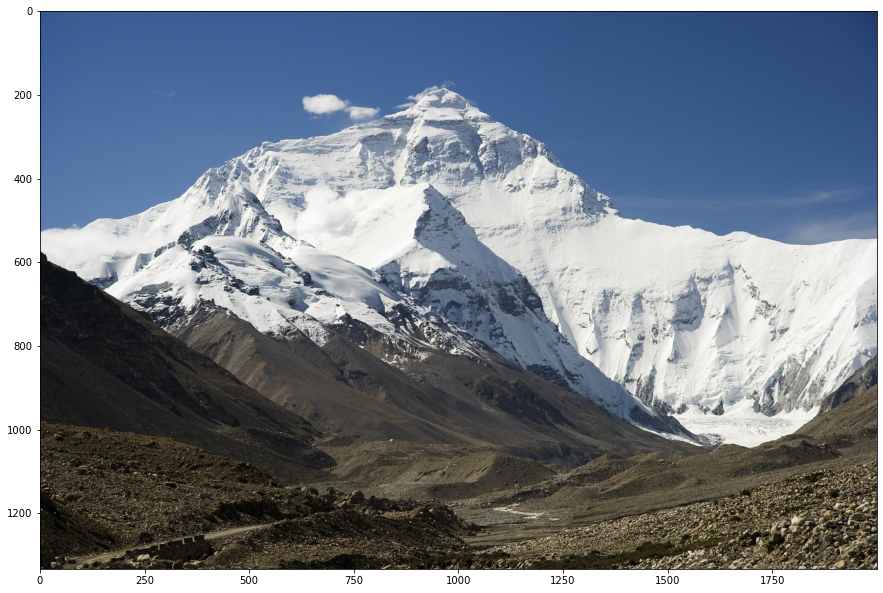

In [21]:
img = cv2.imread('content/mountain.jpg')
show_pic(img)

# ENCODER FUNCTION

In [22]:
def encode_data(img, data):
    
    list1=[ ]
    
    if (len(data) == 0): 
      raise ValueError('Data is empty')
  
    filename = input("Enter the name of the New Image after Encoding(without extension):")
    filename += '.png'
    
    no_bytes=(img.shape[0] * img.shape[1] * 3) // 8
    
    print("Maximum bytes to encode:", no_bytes-3)
    
    
#     # Using the below as delimeter
    delim = b'***'
    data+=delim
    
    if(len(data)>no_bytes):
        raise ValueError("Error encountered Insufficient bytes, Need Bigger Image or give Less Data !!")
        
    data_binary= cipher2binary(data)
    print(data_binary)
    
    #number of bits
    data_len=len(data_binary)
    
    print("The Length of Binary data",data_len)
    
    data_index = 0
    
    for row in img:
        for pixel in row:
          r, g, b = message2binary(pixel)

          if data_index < data_len:
              # hiding the data into LSB(Least Significant Bit) of Red Pixel
              pixel[0] = int(r[:-1] + data_binary[data_index], 2) #changing to binary after overwrriting the LSB bit of Red Pixel
              data_index += 1
              list1.append(pixel[0])

          if data_index < data_len:
             # hiding the data into LSB of Green Pixel
              pixel[1] = int(g[:-1] + data_binary[data_index], 2) #changing to binary after overwrriting the LSB bit of Green Pixel
              data_index += 1
              list1.append(pixel[1])

          if data_index < data_len:
              # hiding the data into LSB of  Blue Pixel
              pixel[2] = int(b[:-1] + data_binary[data_index], 2) #changing to binary after overwrriting the LSB bit of Blue pixel
              data_index += 1
              list1.append(pixel[2])

              # if data is encoded, just breaking out of the Loop
          if data_index >= data_len:
              break

    cv2.imwrite(filename,img)
    
    print("Encoded the data successfully and the image is successfully saved as ",filename)

In [23]:
def decode_data(img):

  finished = False
  counter = 0
  binary_data = ''
  decoded_data = b''
  pixels_count = (img.shape[0] * img.shape[1] * 3)
  
  for row in img:
      for pixel in row:
        
          r, g, b = message2binary(pixel) 
          binary_data += r[-1]  #Extracting Encoded data from the LSB bit of Red Pixel as we have stored in LSB bit of every pixel.
          binary_data += g[-1]  #Extracting Encoded data from the LSB bit of Green Pixel
          binary_data += b[-1]  #Extracting Encoded data from LSB bit of Blue Pixel
          counter += 3
          
          # last 3 bytes
          if(counter%24 == 0) or counter == pixels_count:
              # splitting last 3 bytes by 8-bits
              last3bytes = [ binary_data[i: i+8] for i in range(0, len(binary_data), 8) ]
#               print(last3bytes)
              for byte in last3bytes:
                  b = int(byte, 2).to_bytes((len(byte) + 7) // 8, 'big')
                  decoded_data += b
                  if decoded_data[-3:] == b"***": #Checking if we have reached the delimeter which is "*****"
                      finished = True
                      break
                    
              binary_data = ""
              last3bytes = []
          if finished:
              break
      if finished:
        break
                
  print("The Encoded data was :--",decoded_data[:-3])
  return decoded_data[:-3]

In [24]:
def encrypt(key, plaintext):
    # Generate a random 96-bit IV.
    iv = os.urandom(12)

    # Construct an AES-GCM Cipher object with the given key and a
    # randomly generated IV.
    encryptor = Cipher(
        algorithms.AES(key),
        modes.GCM(iv),
    ).encryptor()


    # Encrypt the plaintext and get the associated ciphertext.
    # GCM does not require padding.
    ciphertext = encryptor.update(plaintext)

    return (iv, ciphertext)

def decrypt(key, iv, ciphertext):
    # Construct a Cipher object, with the key, iv, and additionally the
    # GCM tag used for authenticating the message.
    decryptor = Cipher(
        algorithms.AES(key),
        modes.GCM(iv),
    ).decryptor()


    # Decryption gets us the authenticated plaintext.
    # If the tag does not match an InvalidTag exception will be raised.
    return decryptor.update(ciphertext)



In [ ]:
key = os.urandom(32)
message = "Mostafa"
iv, ciphertext = encrypt(key, message.encode('utf-8'))
print(message)
print(message.encode('utf-8'))
print(ciphertext)
print(ciphertext[0])

# hide data in image
encode_data(img, ciphertext)

Mostafa
b'Mostafa'
b'K\x92)hd\xfaT'
75


In [ ]:
encryptedImage = cv2.imread("content/encrypted.png")
c = decode_data(encryptedImage)
print(c)
dec = decrypt(key, iv, c)
print(dec.decode('utf-8'))